## Genre Classifier - Find your genre based on your chosen features

### Imports

In [1]:
# Core libs
import numpy as np
import pandas as pd

# Scikit-learn – modelling & metrics
from sklearn.preprocessing   import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline        import Pipeline
from sklearn.metrics         import (
    accuracy_score,
    classification_report,
    confusion_matrix,
)

from imblearn.over_sampling import SMOTE

# A quick, robust multi-class model
from sklearn.ensemble import RandomForestClassifier

In [2]:
bb = pd.read_csv('../../data/billboard_100_processed.csv')
bb.head()

,index,SongID,Performer,Song,spotify_genre,spotify_track_id,spotify_track_preview_url,spotify_track_duration_ms,spotify_track_explicit,spotify_track_album,...,Instance,Previous Week Position,Peak Position,Weeks on Chart,Year,Month,WeekStart,WeekIndex,Genre,inv_pos
0,0,......And Roses And RosesAndy Williams,Andy Williams,......And Roses And Roses,"['adult standards', 'brill building pop', 'eas...",3tvqPPpXyIgKrm4PR9HCf0,https://p.scdn.co/mp3-preview/cef4883cfd1e0e53...,166106.0,False,The Essential Andy Williams,...,1,NaN,78,1,1965,April,1965-04-03,1,Easy Listening,0.012821
1,0,......And Roses And RosesAndy Williams,Andy Williams,......And Roses And Roses,"['adult standards', 'brill building pop', 'eas...",3tvqPPpXyIgKrm4PR9HCf0,https://p.scdn.co/mp3-preview/cef4883cfd1e0e53...,166106.0,False,The Essential Andy Williams,...,1,NaN,78,1,1965,April,1965-04-03,1,Pop,0.012821
2,0,......And Roses And RosesAndy Williams,Andy Williams,......And Roses And Roses,"['adult standards', 'brill building pop', 'eas...",3tvqPPpXyIgKrm4PR9HCf0,https://p.scdn.co/mp3-preview/cef4883cfd1e0e53...,166106.0,False,The Essential Andy Williams,...,1,NaN,78,1,1965,April,1965-04-03,1,Easy Listening,0.012821
3,0,......And Roses And RosesAndy Williams,Andy Williams,......And Roses And Roses,"['adult standards', 'brill building pop', 'eas...",3tvqPPpXyIgKrm4PR9HCf0,https://p.scdn.co/mp3-preview/cef4883cfd1e0e53...,166106.0,False,The Essential Andy Williams,...,1,NaN,78,1,1965,April,1965-04-03,1,Easy Listening,0.012821
4,760,(The Bees Are For The Birds) The Birds Are For...,The Newbeats,(The Bees Are For The Birds) The Birds Are For...,['northern soul'],7eGLhn6AJNiXJUS7VawiUK,https://p.scdn.co/mp3-preview/c931d8624762f331...,133706.0,False,The Newbeats,...,1,NaN,74,1,1965,April,1965-04-03,1,Soul,0.013514


## Feature engineering, normalizing and balancing

In [3]:
# ------------------------------------------------------------
# 0.  DATA PREPARATION
# ------------------------------------------------------------

bb = bb.drop_duplicates(subset=["Song", "Performer"])
features = [
    "danceability", "energy", "key", "loudness", "mode",
    "speechiness", "acousticness", "instrumentalness", "liveness",
    "valence", "tempo", "time_signature"
]
X = bb[features].copy()
y = bb["Genre"].copy()

# Label-encode the target into 0 … n-1 integers
le   = LabelEncoder()
y_le = le.fit_transform(y)

# Train/test with **stratification** so every genre is represented
X_train, X_test, y_train, y_test = train_test_split(
    X, y_le, test_size=0.20, random_state=42, stratify=y_le
)

# ------------------------------------------------------------
# 1.  PIPELINE
#     • Min-Max scaling → puts every feature on 0-to-1
#     • RandomOverSampler → clones minority-class samples
#     • LogisticRegression → multi-class classifier
# ------------------------------------------------------------

# Normalize features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Set k_neighbors to 1 less than the smallest class count
min_class_size = pd.Series(y_train).value_counts().min()

# Must be ≥2 for SMOTE to work
k = max(min_class_size - 1, 1)

smote = SMOTE(random_state=42, k_neighbors=k)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

# Train random forest classifier
clf = RandomForestClassifier(
    n_estimators=25,
    max_depth=15,
    random_state=42,
    class_weight="balanced",
)

clf.fit(X_train_bal, y_train_bal)

RandomForestClassifier(class_weight='balanced', max_depth=15, n_estimators=25,
                       random_state=42)

### 2 Evaluation – overall & per-class accuracy

In [4]:
# Predict and evaluate
y_pred = clf.predict(X_test_scaled)
# Decode predictions and ground truth to genre names (optional for readability)
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

# Print overall accuracy
overall_acc = accuracy_score(y_test, y_pred)
print(f"✅ Overall accuracy: {overall_acc:.3f}\n")

# Detailed classification report (per-class precision, recall, F1)
print("📊 Classification report:")
print(classification_report(
    y_test_labels,
    y_pred_labels,
    target_names=le.classes_,
    digits=3,
    zero_division=0
))

# Confusion matrix and per-class accuracy
cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(le.classes_)))
per_class_acc = cm.diagonal() / cm.sum(axis=1)

acc_table = pd.DataFrame({
    "Genre": le.classes_,
    "Accuracy": per_class_acc.round(3)
}).sort_values("Accuracy", ascending=False)

print("\n🎯 Per-class accuracy table:")
display(acc_table)


✅ Overall accuracy: 0.281

📊 Classification report:
                  precision    recall  f1-score   support

           Blues      0.024     0.059     0.034        17
       Classical      0.000     0.000     0.000         4
          Comedy      0.000     0.000     0.000         7
         Country      0.358     0.486     0.412       222
           Dance      0.240     0.377     0.293       106
  Easy Listening      0.323     0.357     0.339       381
      Electronic      0.067     0.111     0.083        27
            Folk      0.030     0.094     0.046        32
            Funk      0.022     0.032     0.026        31
         Hip Hop      0.560     0.761     0.645       251
         Holiday      0.000     0.000     0.000         4
           Indie      0.000     0.000     0.000         5
            Jazz      0.000     0.000     0.000        21
           Latin      0.125     0.273     0.171        22
           Metal      0.183     0.435     0.258        46
           Other   

,Genre,Accuracy
9,Hip Hop,0.761
3,Country,0.486
14,Metal,0.435
4,Dance,0.377
5,Easy Listening,0.357
13,Latin,0.273
20,Rock,0.262
22,Soul,0.209
23,Soundtrack,0.191
16,Pop,0.146


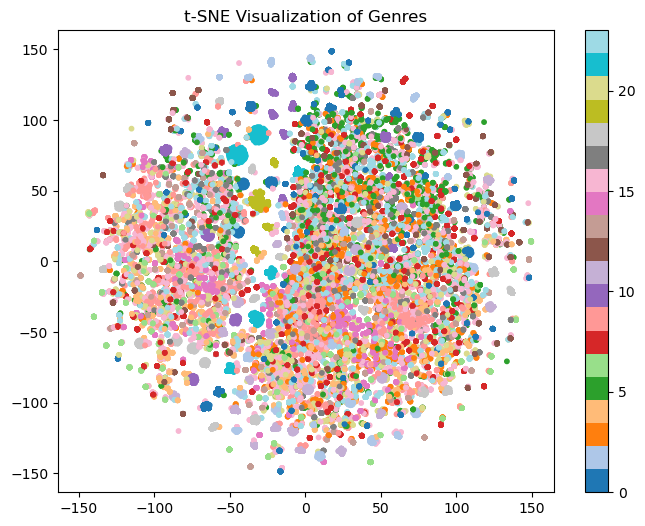

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X_embedded = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_train_bal)
plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_train_bal, cmap="tab20", s=10)
plt.title("t-SNE Visualization of Genres")
plt.colorbar()
plt.show()


## Save Model

In [5]:
import gzip
import pickle
from pathlib import Path

model_dir = Path("model")
model_dir.mkdir(exist_ok=True)

with gzip.open(model_dir / "genre_classifier.pkl.gz", "wb") as f:
    pickle.dump(clf, f)
with gzip.open(model_dir / "scaler.pkl.gz", "wb") as f:
    pickle.dump(scaler, f)
with gzip.open(model_dir / "label_encoder.pkl.gz", "wb") as f:
    pickle.dump(le, f)

## Load them later

In [6]:
with gzip.open("model/genre_classifier.pkl.gz", "rb") as f:
    clf = pickle.load(f)
with gzip.open("model/scaler.pkl.gz", "rb") as f:
    scaler = pickle.load(f)
with gzip.open("model/label_encoder.pkl.gz", "rb") as f:
    le = pickle.load(f)

In [8]:
le.inverse_transform(clf.predict(X_test_scaled[15:25]))

array(['Pop', 'R&B', 'Country', 'Easy Listening', 'Blues',
       'Easy Listening', 'Pop', 'Rock', 'Country', 'Funk'], dtype=object)